# Customer_Segmentation_Using-Kmeans

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#Introduction">Introduction</a></li>
        <li><a href="https://#Data Cleaning and EDA">Data Cleaning and EDA</a></li>
        <li><a href="https://#RFM Segmentation">RFM Segmentation</a></li>
        <li><a href="https://#Modeling : K - Means Clustering">Modeling : K - Means Clustering</a></li> 
        <li><a href="https://#Conclusions">Conclusions</a></li> 
    </ol>
</div>
<br>
<hr>

In [1]:
from IPython.display import Image
import os
!ls ../input/segmentation

Micros-segmentation.png


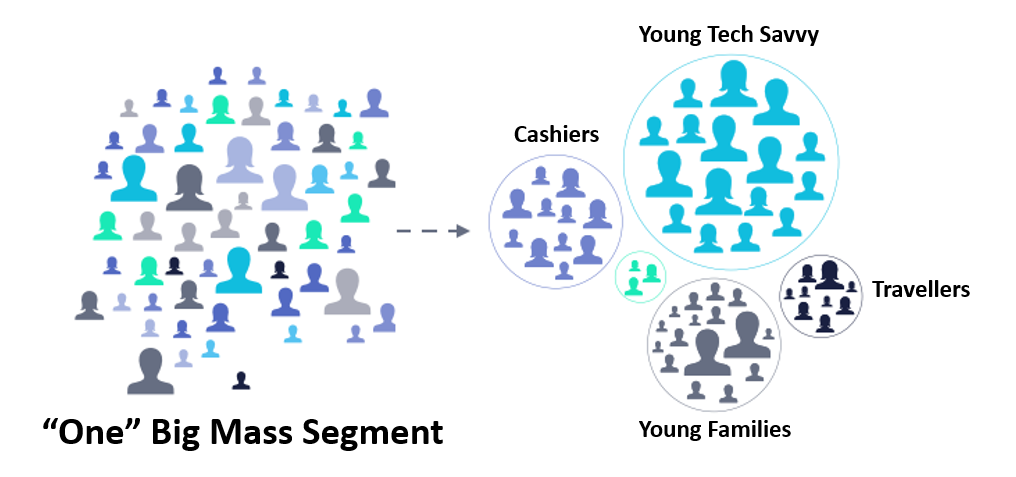

In [2]:
Image('/kaggle/input/segmentation/Micros-segmentation.png')

<h2 id="1.Introduction">1.Introduction</h2>

<h3 id="1.1 Data Description">1.1 Data Description</h3>

***InvoiceNo:*** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

***StockCode:*** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product

***Description:*** Product (item) name. Nominal.

***Quantity:*** The quantities of each product (item) per transaction. Numeric.

***InvoiceDate:*** Invoice Date and time. Numeric, the day and time when each transaction was generated

***UnitPrice:*** Unit price. Numeric, Product price per unit in sterling.

***CustomerID:*** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer

***Country:*** Country name. Nominal, the name of the country where each customer resides

<h3 id="1.2 Import Libraries And Load Data">1.2 Import Libraries And Load Data</h3>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

- Reading csv file and checking data types and null value information using info

In [4]:
online=pd.read_csv('/kaggle/input/retail-csmt/OnlineRetail.csv',encoding='iso-8859-1')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# Check type and null value in DataFrame
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Descriptive Statictis Analytics**

In [6]:
online.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<h2 id="2. Data Clearning  And EDA">2. Data Clearning  And EDA </h2>

**Checking for duplicates**

In [7]:
online.shape

(541909, 8)

In [8]:
print('Shape before dropping duplicates',online.shape)
online=online.drop_duplicates()
print('Shape after dropping duplicates',online.shape)

Shape before dropping duplicates (541909, 8)
Shape after dropping duplicates (536641, 8)


**Checking unique values in differnt columns**

In [9]:
online[["InvoiceNo","StockCode","InvoiceDate","CustomerID", "Country"]].nunique()

InvoiceNo      25900
StockCode       4070
InvoiceDate    23260
CustomerID      4372
Country           38
dtype: int64

**Checking null value in CustomerID**

In [10]:
print(np.sum(online.isnull()), "\n")
print("Percentage of customers missing: ", round(online['CustomerID'].isnull().sum() * 100 / len(online),2),"%" )

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64 

Percentage of customers missing:  25.16 %


In [11]:
online['CustomerID'].isnull().sum() 

135037

- Check if invoiceNo fir Null Customer ID exist in case Where Customer ID is present for filling CustomerID Nulls

In [12]:
null_id_invoices=online[online.CustomerID.isnull()]['InvoiceNo'].drop_duplicates().tolist()
print("Invoices count with Null Customer ID", len(null_id_invoices))
## Check if InvoiceNo in Null CustomerID dataframe exist in Non-Null Customer ID Dataframe
online[~online.CustomerID.isnull()][online.InvoiceNo.isin(null_id_invoices)]

Invoices count with Null Customer ID 3710


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Since the customer ID's are missing, I assume these orders were not made by the customers already in the data set because those customers already have ID's. I also don't want to assign these orders to those customers because this would alter the insights I draw from the data. Instead of dropping the null CustomerID values which amounts to ~25% of data, let's assign those rows a unique customer ID per order using InvoiceNo. This will act as a new customer for each unique order.

Check if InvoiceNo has unique mapping with Customer ID so that each InvoiceNo corresponding to Null CustomerID can be assigned as New Customer

In [13]:
online.groupby(['InvoiceNo'])['CustomerID']\
                            .unique()\
                            .reset_index(name='nunique')\
                            .sort_values(['nunique'],ascending=False)\
                            .head(5)

,InvoiceNo,nunique
21692,580872,[18283.0]
13046,563193,[nan]
13791,564762,[nan]
13016,563160,[nan]
13012,563148,[nan]


**On sorting descending :** This data shows that each Invoice relates to maximum of 1 Customer. Creating NewID column and Assigning whereever CustomerID is null.

In [14]:
online['NewID']=online['CustomerID']
online.loc[online['CustomerID'].isnull(),['NewID']]=online['InvoiceNo']

# Remove all non digits from column NewID (Since Invoice can contains "C" refering to cancellations)
online['NewID']=online['NewID'].astype(str).str.replace('\D+','')

# Convert to integer

online['NewID']=pd.to_numeric(online['NewID'])

### Check if present CustomerIDs and New Ids have any common values since it would create alteractual Customer Insights
customer=online['CustomerID'].nunique()
null_invoices=online[online.CustomerID.isnull()]['InvoiceNo'].nunique()
new_ids=online['NewID'].nunique()
print(f"Number of Customers: {customer}")
print(f"Number of Orders where CustomerID in Null: {null_invoices}" )
print(f"Total Number of Customers and Number of Orders where CustomerID in Null: {customer + null_invoices}" )
print(f"Number of New ID's: {new_ids}")

Number of Customers: 4372
Number of Orders where CustomerID in Null: 3710
Total Number of Customers and Number of Orders where CustomerID in Null: 8082
Number of New ID's: 8082


- The difference oerders that didn't have a customer ID got assigned unique NewID and no duplicates were created.

**Converitng :** object type to datetime for InvoiceDate and checking first and last dates

In [15]:
online['InvoiceDate']=pd.to_datetime(online['InvoiceDate'])
#Minimum Invoice Date
Min_Date=min(online['InvoiceDate'])
# Maximum Invoice Date
Max_Date=max(online['InvoiceDate'])
print(f"Minimum Invoice Date: {Min_Date}")
print(f"Maximum Invoice Date: {Max_Date}")

Minimum Invoice Date: 2010-12-01 08:26:00
Maximum Invoice Date: 2011-12-09 12:50:00


- Adding cancellations column based on definition that InvoiceNo Starts with c

In [16]:
online["cancellations"] = np.where(online["InvoiceNo"].str.startswith('C'), 1,0)
total_online = online["InvoiceNo"].shape[0]
cancelled_online = online[online.cancellations == 1].shape[0]
print("Number of cancelled products data", cancelled_online, cancelled_online*100/total_online, "\n")

print(online[online.cancellations == 1]["Quantity"].describe())

#### Removing cancellations since they have negative quantities and makes only ~2% of data
online = online[online.cancellations == 0]

Number of cancelled products data 9251 1.7238712658928408 

count     9251.000000
mean       -29.787050
std       1147.997592
min     -80995.000000
25%         -6.000000
50%         -2.000000
75%         -1.000000
max         -1.000000
Name: Quantity, dtype: float64


- Analysis of Unit Price variable

In [17]:
min_UnitPrice=min(online['UnitPrice'])
max_UnitPrice=max(online['UnitPrice'])
print(f'Minimum UnitPrice : {min_UnitPrice}')
print(f'Maximum UnitPrice : {max_UnitPrice}')
# Checking min
online['UnitPrice'].describe()

Minimum UnitPrice : -11062.06
Maximum UnitPrice : 13541.33


count    527390.000000
mean          3.861939
std          41.963759
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

- Checking cases where Price<0


In [18]:
online[online.UnitPrice<0].transpose()

,299983,299984
InvoiceNo,A563186,A563187
StockCode,B,B
Description,Adjust bad debt,Adjust bad debt
Quantity,1,1
InvoiceDate,2011-08-12 14:51:00,2011-08-12 14:52:00
UnitPrice,-11062.06,-11062.06
CustomerID,NaN,NaN
Country,United Kingdom,United Kingdom
NewID,563186,563187
cancellations,0,0


In [19]:
online=online[online.UnitPrice>=0]

In [20]:
Percent_Price=round(len(online[online.UnitPrice == 0]) * 100 / len(online),2)
print(f"Percent of online with Price = 0: {Percent_Price}")
Count_ID=online[online.UnitPrice == 0].CustomerID.nunique()
print(f"Count of unique Customer ID values : {Count_ID}")
online[online.UnitPrice == 0][~online.CustomerID.isnull()].head(5)

Percent of online with Price = 0: 0.48
Count of unique Customer ID values : 31


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,126470,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,165600,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,149110,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,130810,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,130810,0


In [21]:
### Droping case with UnitPrice =0
online_filtered = online[online.UnitPrice>0]
online_filtered['UnitPrice'].describe()

count    524878.000000
mean          3.922573
std          36.093028
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [22]:
# Min and Max quantity online_filtered
Min_Quantity=min(online_filtered["Quantity"])
print(f"Minimum Quantity : {Min_Quantity}")
Max_Quantity=max(online_filtered["Quantity"])
print(f"Maximum Quantity : {Max_Quantity}")
# Check descibe
online_filtered["Quantity"].describe()

Minimum Quantity : 1
Maximum Quantity : 80995


count    524878.000000
mean         10.616600
std         156.280031
min           1.000000
25%           1.000000
50%           4.000000
75%          11.000000
max       80995.000000
Name: Quantity, dtype: float64

- Customer and Total revenue split wrto country

In [23]:
### Adding Monetary information by calculating total value of transaction by multiplying unit price and quantity of the product
online_filtered["Total_sales"] = online_filtered["UnitPrice"]*online_filtered["Quantity"]

### Creating Country Level grouping to find Unique Customer count and %
country_customer_df = online_filtered.groupby("Country")["CustomerID"].nunique().reset_index().rename(columns = \
                                                                                           {"CustomerID":"count_CustomerID"})
country_customer_df["customer_%"] = round(country_customer_df["count_CustomerID"]*\
                                          100/country_customer_df["count_CustomerID"].sum(),2)

### Creating Country Level grouping to find total revenue and %
country_df = online_filtered.groupby("Country")["Total_sales"].sum().reset_index()
country_df["Total_sales%"] = round(country_df["Total_sales"]*100/country_df["Total_sales"].sum(),2)

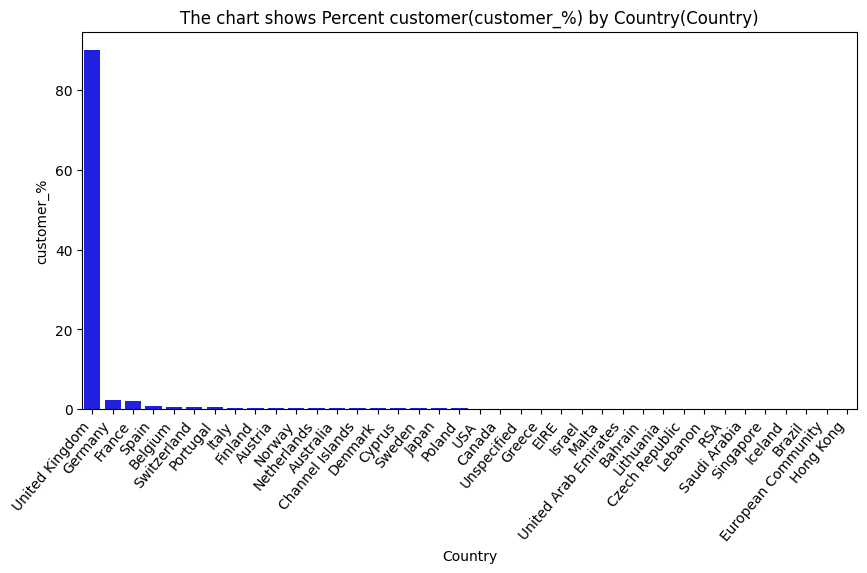

In [24]:
country_customer_df = country_customer_df.sort_values(by = "customer_%", ascending = False)
fig, ax = plt.subplots(figsize=(10,5),dpi=100)
ax=sns.barplot(x=country_customer_df["Country"], y=country_customer_df['customer_%'],color="blue")
ax.set_title("The chart shows Percent customer(customer_%) by Country(Country)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()



The United Kingdom not only has the most sales revenue, but also the most customers. Therefore, for the purpose of this analysis, I will be taking data corresponding to orders from the United Kingdom.

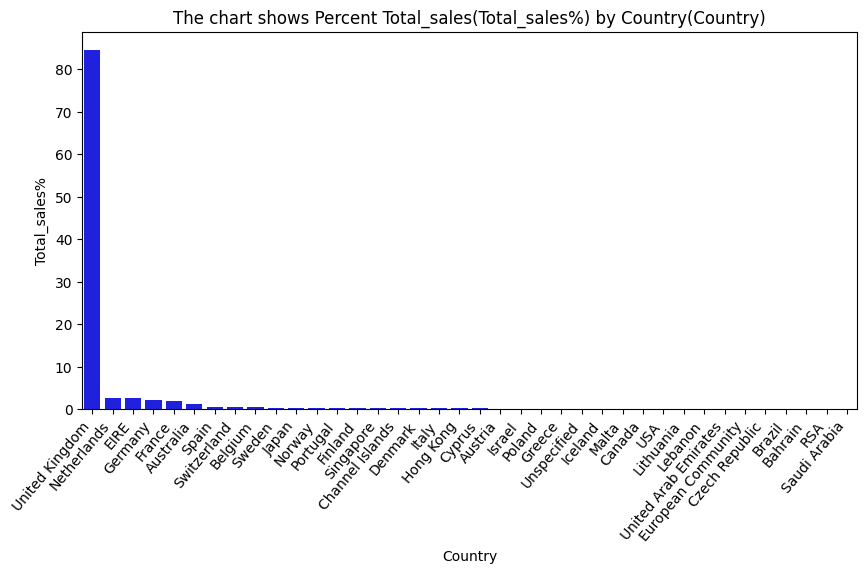

In [25]:
country_df = country_df.sort_values(by = "Total_sales%", ascending = False)
fig, ax = plt.subplots(figsize=(10,5),dpi=100)
ax=sns.barplot(x=country_df["Country"], y=country_df['Total_sales%'],color="blue")
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.set_title("The chart shows Percent Total_sales(Total_sales%) by Country(Country)")
plt.show()

In [26]:
uk_df = online_filtered[online_filtered.Country == "United Kingdom"]
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479985 entries, 0 to 541893
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   InvoiceNo      479985 non-null  object        
 1   StockCode      479985 non-null  object        
 2   Description    479985 non-null  object        
 3   Quantity       479985 non-null  int64         
 4   InvoiceDate    479985 non-null  datetime64[ns]
 5   UnitPrice      479985 non-null  float64       
 6   CustomerID     349203 non-null  float64       
 7   Country        479985 non-null  object        
 8   NewID          479985 non-null  int64         
 9   cancellations  479985 non-null  int64         
 10  Total_sales    479985 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 43.9+ MB


- Checking Most popular products in United Kingdom

In [27]:
uk_product = uk_df.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', \
                                                                                                      ascending=False)
uk_product.head(5)

,StockCode,Description,Quantity
2653,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
2112,23166,MEDIUM CERAMIC TOP STORAGE JAR,77036
3113,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49430
3601,85099B,JUMBO BAG RED RETROSPOT,44161
3622,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35430


In [28]:
#Find the unique number of InvoiceNo  per customer for analysis of United Kingdom 
groupby_customers = pd.DataFrame(uk_df.groupby('NewID')['InvoiceNo'].nunique())
groupby_customers.describe()

,InvoiceNo
count,5293.000000
mean,3.404308
std,6.356634
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,209.000000


In [29]:
# Find the unique number of products per Order
groupby_invoice=pd.DataFrame(uk_df.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns=['Number of products per Order']
groupby_invoice.describe()

,Number of products per Order
count,18019.000000
mean,26.351129
std,48.882851
min,1.000000
25%,6.000000
50%,15.000000
75%,29.000000
max,1110.000000


### 3. RFM Segmentation
RFM is a data modeling method used to analyze customer value. It stands for recency, frequency, and monetary, which are just three metrics that describe what your customers did.

***Recency (R) of a customer:*** Days since the last purchase.

***Frequency (F) of the bookings/turnover of a customer:*** Number of purchases, e.g., in 6 months.

***Monetary (M) - The total turnover of a customer:*** Sum of sales, e.g., in 6 months.

For the analysis, we need to define a ‘analysis date’, which is the day on which we are conducting this analysis which I am taking as the next to last date in data and taking 1 year previous data from the selected date for recency calculation

In [30]:
analysis_date = uk_df["InvoiceDate"].max() + pd.DateOffset(1)
print(f"RFM Analysis Date : {analysis_date}" )

start_date = analysis_date - pd.DateOffset(days = 365)
print(f"Start Date when taking 1 year data for analysis : {start_date}" )

RFM Analysis Date : 2011-12-10 12:49:00
Start Date when taking 1 year data for analysis : 2010-12-10 12:49:00


- I will now drop rows with Nulls as customerID since these fake customer ID's would skew the analysis, especially the frequency. Aggregating Remaining dataset to calculate recency, frequency and monetary value columns for every customerID

In [31]:
### Drop Nulls in CustomerID
uk_df = uk_df[~uk_df.CustomerID.isnull()]

# Aggregate data on a customer level to get RFM values
data_rfm = uk_df[uk_df.InvoiceDate >= start_date].groupby(['NewID'],as_index=False).agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
'InvoiceNo': 'count','Total_sales': 'sum'}).rename(columns = {'InvoiceDate': 'Recency', \
                                            'InvoiceNo': 'Frequency','Total_sales': 'Monetary'})
data_rfm.head()

,NewID,Recency,Frequency,Monetary
0,123460,326,1,77183.60
1,127470,2,96,3837.45
2,127480,1,3899,30298.80
3,127490,4,199,4090.88
4,128200,3,59,942.34


In [32]:
### Getting individual RFM scores by using quantiles for each of the columns
data_rfm['R_score'] = pd.qcut(data_rfm['Recency'], 4, labels=False)
data_rfm['F_score'] = pd.qcut(data_rfm['Frequency'], 4, labels=False)
data_rfm['M_score'] = pd.qcut(data_rfm['Monetary'], 4, labels=False)

### Since a low Recency score means recent transactions and good customer, changine quantile values 
### so that low values rank highest ans vice versa
data_rfm['R_score'] = 3 - data_rfm['R_score']


### Calculating Final RFM score
data_rfm["RFM_Score"] = data_rfm['R_score'] + data_rfm['F_score'] + data_rfm['M_score']
data_rfm.head(10)

,NewID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,123460,326,1,77183.60,0,0,3,3
1,127470,2,96,3837.45,3,2,3,8
2,127480,1,3899,30298.80,3,3,3,9
3,127490,4,199,4090.88,3,3,3,9
4,128200,3,59,942.34,3,2,2,7
5,128210,214,6,92.72,0,0,0,0
6,128220,71,46,948.88,1,2,2,5
7,128230,75,5,1759.50,1,0,3,4
8,128240,60,25,397.12,1,1,1,3
9,128260,3,82,1319.72,3,2,2,7


***The RFM_Score:*** 
Values will range from 0 (0+0+0) to 9 (3+3+3)

In [33]:
data_rfm.groupby("RFM_Score")[['Recency','Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
RFM_Score,,,
0,241.753799,7.817629,149.276413
1,170.382857,13.728571,225.817457
2,146.484649,19.960526,352.133774
3,87.495349,27.239535,812.044351
4,79.898734,38.779747,716.045114
5,56.645000,52.262500,934.094225
6,43.568733,73.345013,1758.525747
7,31.811370,110.397933,1866.709664
8,20.550595,183.101190,3388.595476


### 4. Modeling : K - Means Clustering

                ----------------- Distribution Plots for Recency,Frequency,Monetary -------------------------------


<AxesSubplot:xlabel='Monetary', ylabel='Density'>

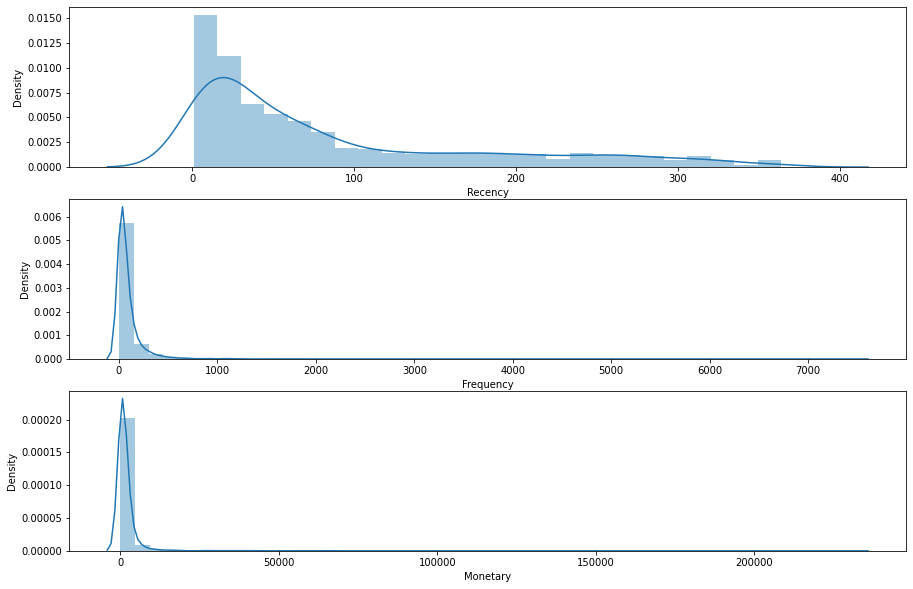

In [34]:
print("                ----------------- Distribution Plots for Recency,Frequency,Monetary -------------------------------")

# Checking the distribution of Recency, Frequency and MonetaryValue variables.
 
plt.figure(figsize=(15,10))
# Plot distribution of var 1
plt.subplot(3,1,1)
sns.distplot(data_rfm['Recency'])

# Plot distribution of var 2
plt.subplot(3,1,2)
sns.distplot(data_rfm['Frequency'])

#Plot distribution of var 3
plt.subplot(3,1,3)
sns.distplot(data_rfm['Monetary'])

       ----------------- Log Transformation Plots for Recency,Recency,Recency -------------------------------


<AxesSubplot:xlabel='log_Monetary', ylabel='Density'>

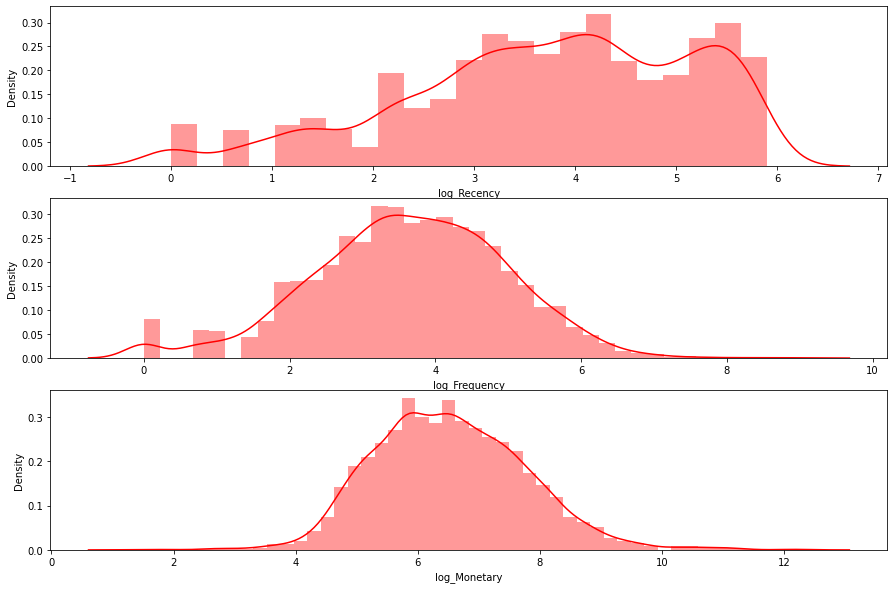

In [35]:
# taking Log of columns 
data_rfm['log_Recency']=np.log(data_rfm.Recency)
data_rfm['log_Frequency']=np.log(data_rfm.Frequency)
data_rfm['log_Monetary']=np.log(data_rfm.Monetary)

# Checking the distribution of Recency, Frequency and Monetary variables after log transformation
print("       ----------------- Log Transformation Plots for Recency,Recency,Recency -------------------------------")
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
sns.distplot(data_rfm['log_Recency'],kde='kde',color='red')
plt.subplot(3,1,2)
sns.distplot(data_rfm['log_Frequency'],kde='kde',color='red')
plt.subplot(3,1,3)
sns.distplot(data_rfm['log_Monetary'],kde="kde",color='red')

**To Find optimal number of clusters :** I will use Elbow method where errors are plotted against K (cluster value) to identify optimal number of clusters

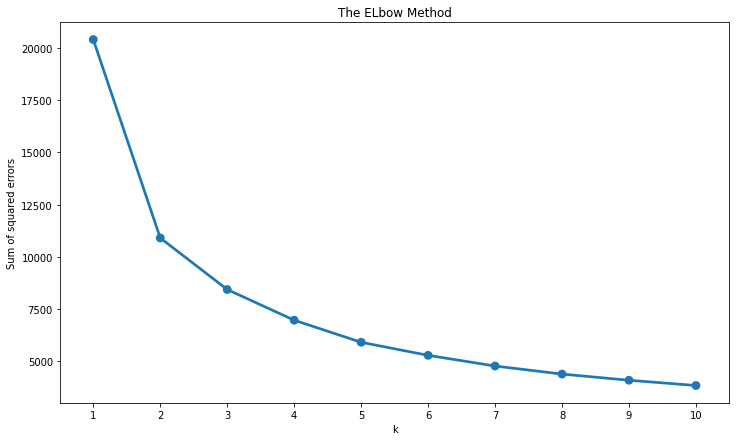

In [36]:
### Features Used in training K Means-Log Transformed Recency, Frequency and Monetary values
data_norm=data_rfm[['log_Recency','log_Frequency','log_Monetary']]

sse={}

# fit KMeans and calculate SSE for each k
for k in range (1,11):
     # Initialize KMeans with K Clusters
    kmeans=KMeans(n_clusters=k,random_state=1)
        
    # Fit KMeans on the Normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to K element of dictionary
    sse[k]=kmeans. inertia_
    
# Plotting the ellbow plot
plt.figure(figsize=(12,7))
plt.title('The ELbow Method')
plt.xlabel('k')
plt.ylabel('Sum of squared errors')
sns. pointplot(x=list(sse.keys()),y=list(sse.values()))
plt.show()

- From the above plot, we can see that the optimal numner oc clusters can be taken as 3. Now I am building the K Means model using 3 cluster. 

In [37]:
n_clusters= 3
kmeans= KMeans(n_clusters=n_clusters,random_state=1)
kmeans.fit(data_norm)
data_rfm['cluster']=kmeans.predict(data_norm)

- Checking Mean RFM values in different clusters to understand cluster Properties

In [38]:
data_rfm.groupby(['cluster'])[['Recency','Frequency','Monetary']].mean()

,Recency,Frequency,Monetary
cluster,,,
0,161.860310,14.482631,284.778781
1,10.477193,240.345029,5452.254316
2,65.715764,67.139988,1183.602485


<AxesSubplot:>

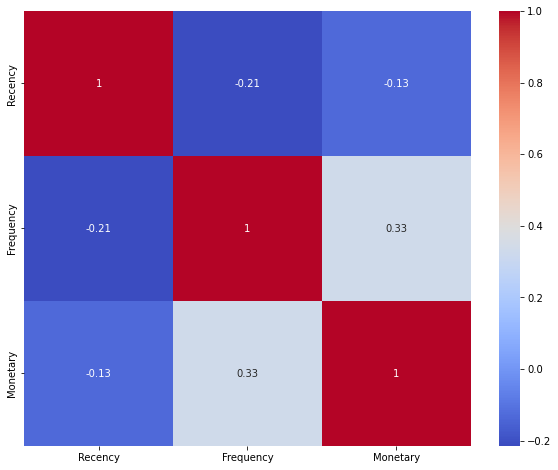

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(data_rfm[['Recency','Frequency','Monetary']].corr(),cmap='coolwarm',annot=True)

Text(0, 0.5, 'Monetary')

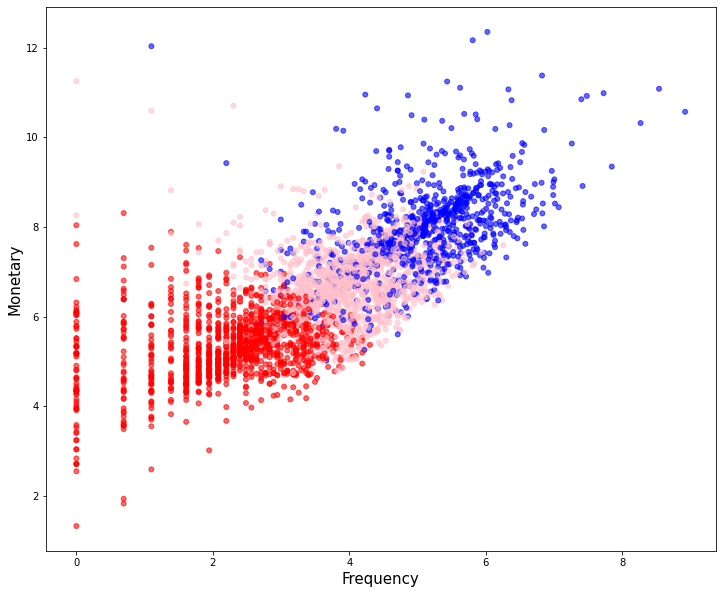

In [40]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to dataframe
data_rfm['cen_x'] = data_rfm.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
data_rfm['cen_y'] = data_rfm.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['red', 'blue', 'pink']
data_rfm['c'] = data_rfm.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

# Plot clusters
plt.figure(figsize=(12,10))
plt.scatter(data_rfm.log_Frequency, data_rfm.log_Monetary, c=data_rfm.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)

### 5. Solution

***This plot clearly indicates that green cluster is high value customer cohort (Cluster 1) and blue cluster is Lost/low value customer cohort (Cluster 2) while red cluster is average value customer cohort (Cluster 0)***

***High Value*** :- Frequent spending customers with high monetary transactions and had transacted recently

***Low Value/ Lost*** :- Customers with least frequency and monetary spending and made purchase long time ago. These customers might be lost from the customer base.

***Average Value*** :- Customers who made their transactions some time ago with less frequency and monetary value. These customers could become high risk and we could aggressively market towards them with great deals so we don't lose them forever.